# Goal

- Link Prediction that predicts future links between facebook pages

### Dataset

- The dataset provides us with target and edges which are both csv files.

- For edges, the features, id_1 and id_2 represent the nodes that will form the graph. The nodes are the values of the features

- Nodes in one row of the dataframe represent links. An example will be shown down below

### Independent and Dependent Variables

We are given a dataset that gives us nodes and each node represents facebook pages. One row of nodes (a pair of nodes) represents a link.

- Target variable: page_type is the target variable

- Features/Independent variable: node_link and page_name. Implementing another relevant feature can improve the accuracy of our model

# Imports

In [ ]:
import pandas as pd
import numpy as np

import json

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt

# Neural Networks
import keras
import tensorflow
import torch
import torchvision
import networkx as nx

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Data

In [ ]:
target_df = pd.read_csv("Data/musae_facebook_target.csv")
edges_df = pd.read_csv("Data/musae_facebook_edges.csv")

In [59]:
# Reading the json as a dict
with open("Data/musae_facebook_features.json") as json_data:
    feature_data_dict = json.load(json_data)
    
features_df = pd.DataFrame.from_dict(feature_data_dict, orient="index")

# Exploratory Data Analysis

In [3]:
print(f"[INFO] This shows the rows and columns of the target dataframe:\nRows: {target_df.shape[0]}\nColumns: {target_df.shape[1]}")
print("-"*60)
print(f"[INFO] This shows the rows and columns of the edges dataframe:\nRows: {edges_df.shape[0]}\nColumns: {edges_df.shape[1]}")

[INFO] This shows the rows and columns of the target dataframe:
Rows: 22470
Columns: 4
------------------------------------------------------------
[INFO] This shows the rows and columns of the edges dataframe:
Rows: 171002
Columns: 2


In [4]:
# Contains the target variables
target_df.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [38]:
# Looking for duplicates
target_df.duplicated().sum()

0

In [5]:
# The edges (id_1 and id_2) represents the nodes that will form the graph
# Nodes in one row of the data frame represent links
edges_df.head()

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [32]:
# Looking for duplicates
edges_df.duplicated().sum()

0

### Node Explanation/Data Explanation

We are using an iloc function to access the rows and columns of the edges dataframe. 

The iloc function below is grabbing node 0 which has a page name/represents The Voice of China in the category/page_type tvshow is connected to node 18427 The Voice Global. This is one link

i.e. node 0, which represents The Voice of China is connected to node 18427, which represents The Voice Global, and both are in the tvshow category. This is all one link.

The page types will also be connected to other pages to form a network.

In [6]:
target_df.iloc[edges_df["id_1"][0]], target_df.iloc[edges_df["id_2"][0]]

(id                                    0
 facebook_id             145647315578475
 page_name      The Voice of China 中国好声音
 page_type                        tvshow
 Name: 0, dtype: object,
 id                        18427
 facebook_id    1563883503866518
 page_name      The Voice Global
 page_type                tvshow
 Name: 18427, dtype: object)

### Node Explanation/Data Explanation

The code below shows node 1 represenets U.S. Consulate General Mumbai and node 21708 represents U.S. Department of State: Bureau of Intl Narco... and both nodes are in the government category. This is one link.

In [7]:
target_df.iloc[edges_df["id_1"][1]], target_df.iloc[edges_df["id_2"][1]]

(id                                         1
 facebook_id                     191483281412
 page_name      U.S. Consulate General Mumbai
 page_type                         government
 Name: 1, dtype: object,
 id                                                         21708
 facebook_id                                         367067283779
 page_name      U.S. Department of State: Bureau of Intl Narco...
 page_type                                             government
 Name: 21708, dtype: object)

# Univariate Analysis

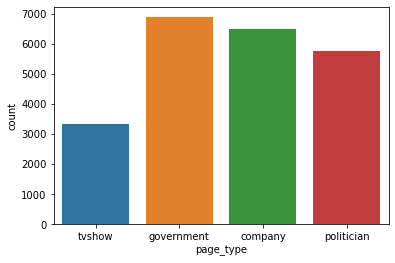

In [8]:
sns.countplot(target_df["page_type"])
plt.show()

# Multivariate Analysis

Graphing the nodes and links

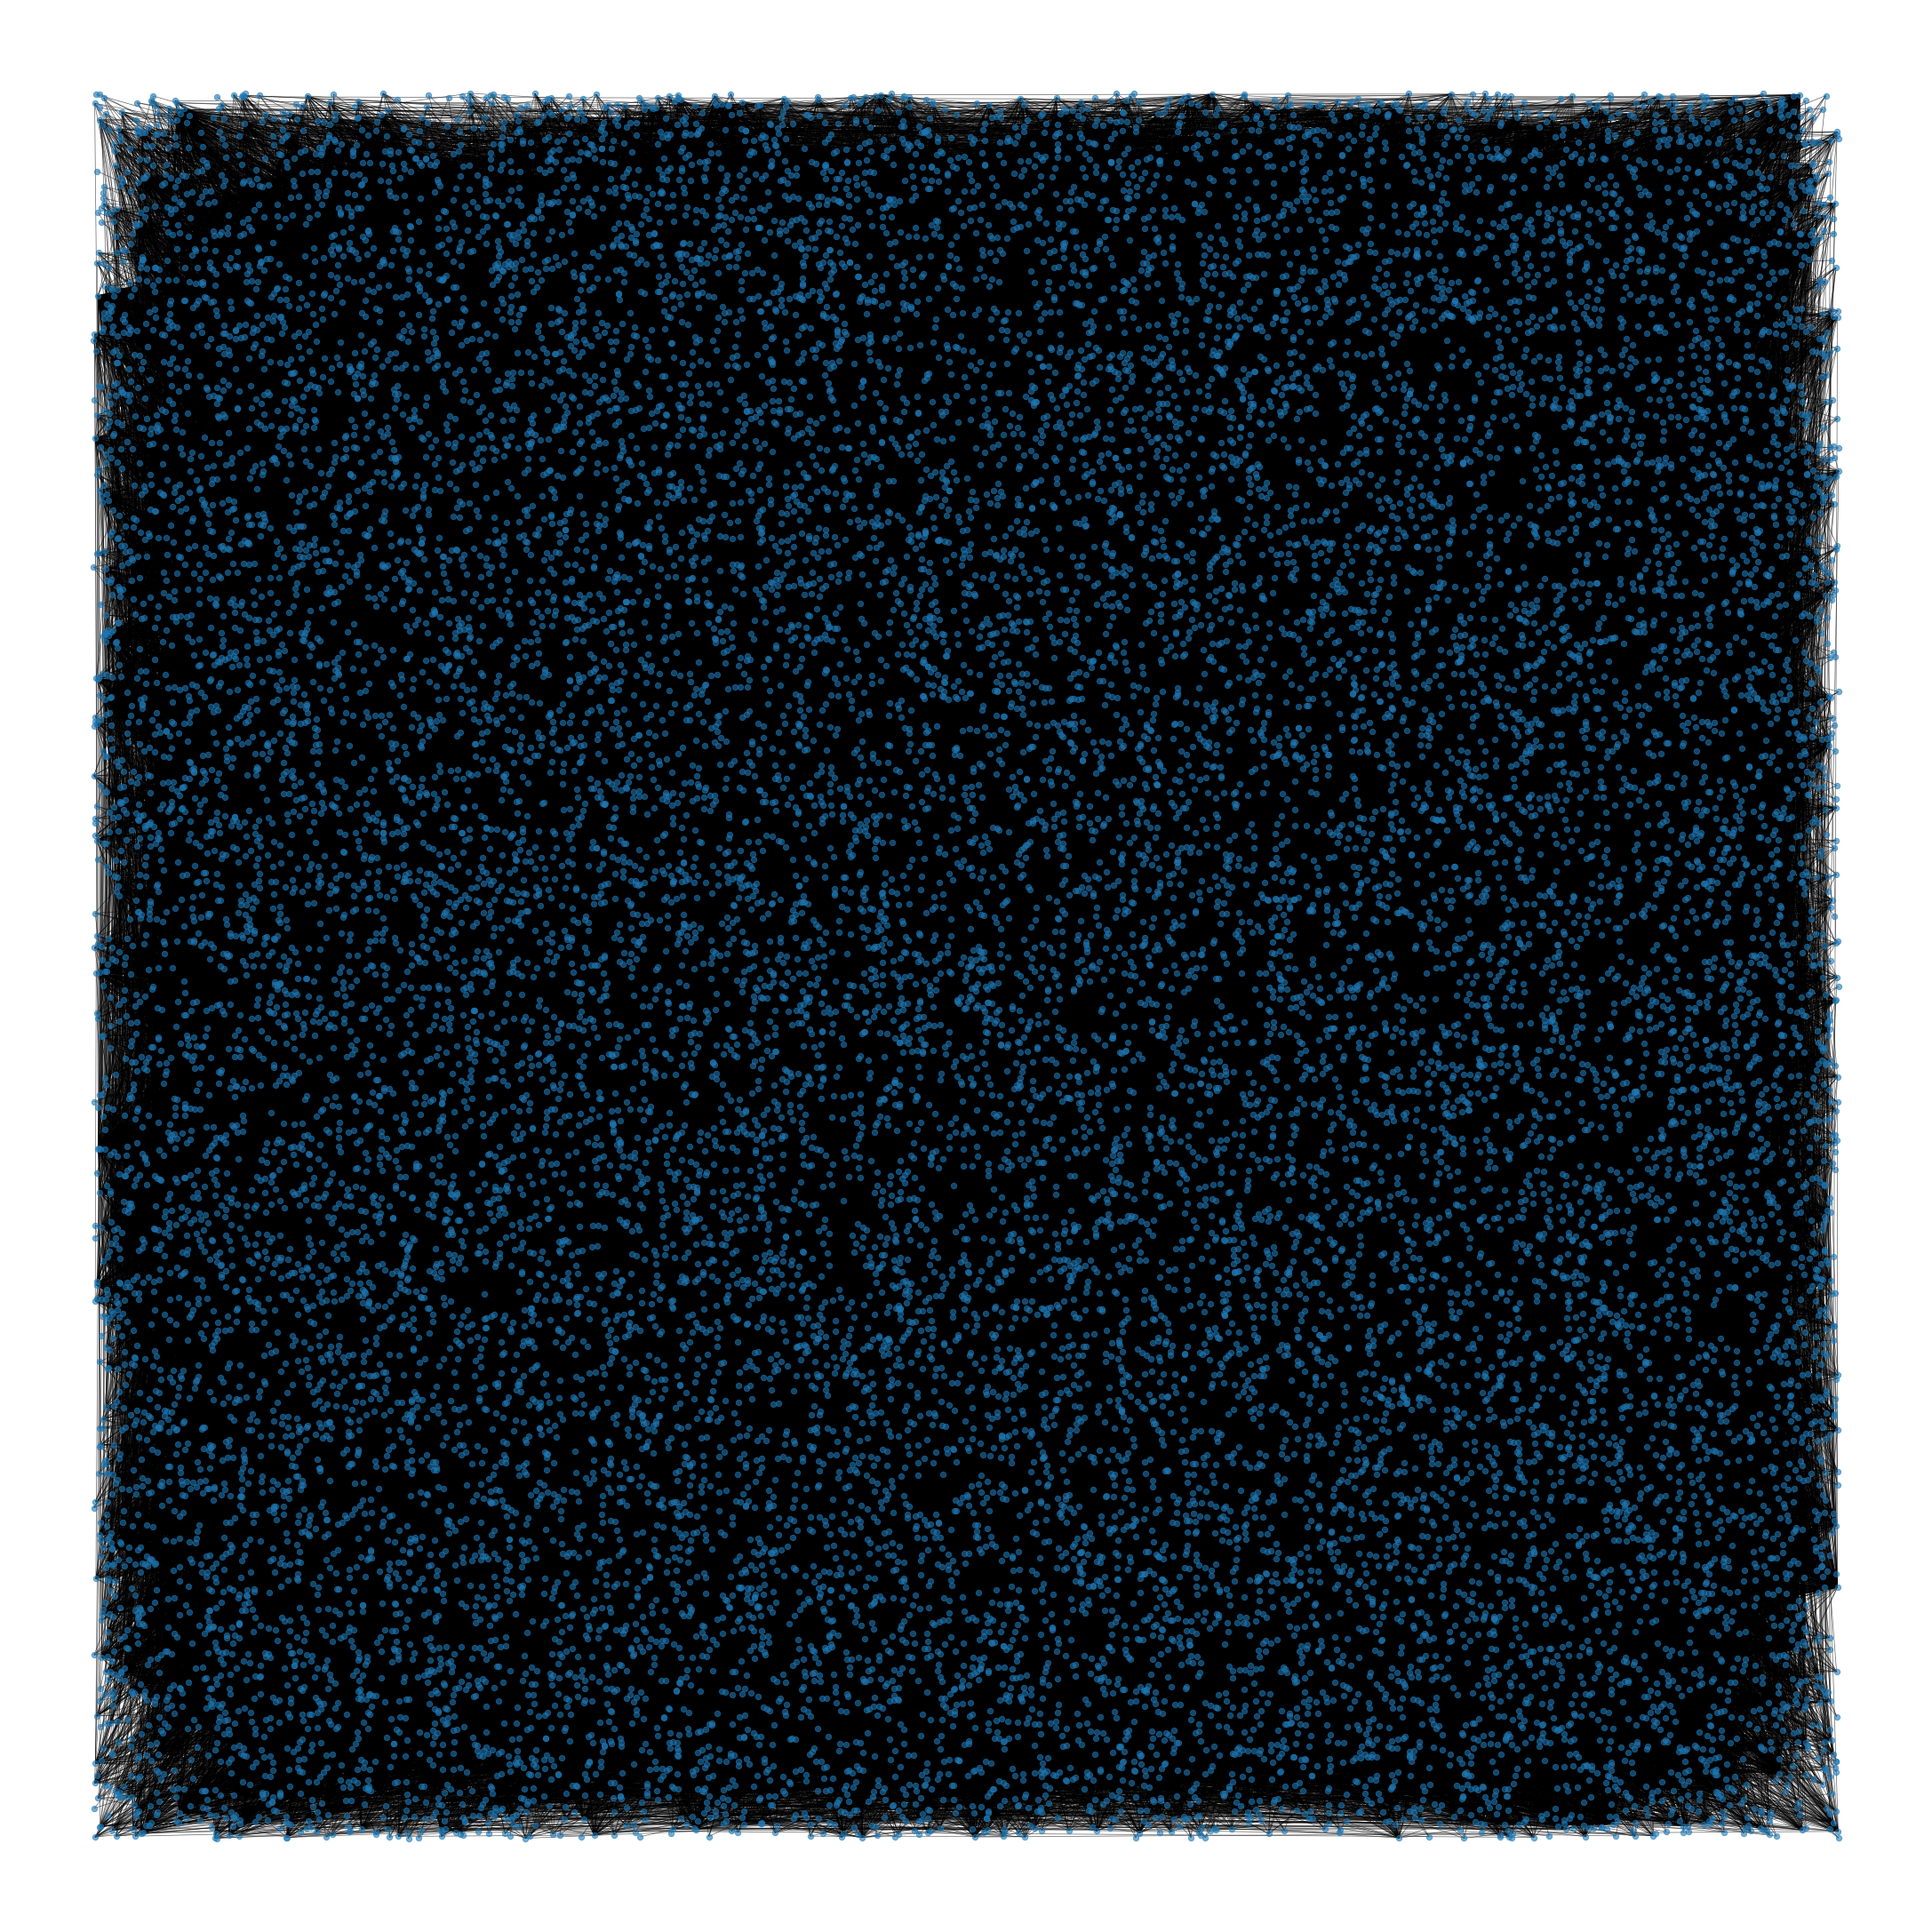

In [9]:
# create graph
G = nx.from_pandas_edgelist(edges_df, "id_1", "id_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(30, 30))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

# Cleaning Data

1. Add a new column to edges dataframe called node_links and rename columns

2. Combine data on index and remove redundant feautures

3. Remove missing values

4. Econding

5. Tokenization

6. Vectorization

1. Add new column to edges dataframe called node_links and rename columns

In [ ]:
edges_df["node_link"] = list(zip(edges_df["id_1"], edges_df["id_2"]))

In [ ]:
# Renaming id_1 and id_2 to node_1 and node_2
edges_df.rename(columns={"id_1": "node_1", "id_2": "node_2"}, inplace=True)

In [ ]:
edges_df.head()

2. Combine data on index and remove redundant features

In [ ]:
# Merging dataframes on index
df = pd.merge(target_df[["page_name", "page_type"]], edges_df[["node_link"]], left_index=True, right_index=True)

print(f"[INFO] The Number of rows and columns will be shown below\nRow: {df.shape[0]}\nColumn: {df.shape[1]}")
df.head()

3. Remove missing values

In [ ]:
# Looking for missing values
df.isna().sum()

4. Encoding

In [ ]:
# Instantiating LabelEncoder
label_encode = LabelEncoder()

In [ ]:
print(f"[INFO] Unique values of page_type: {df.page_type.unique()}")
# Label encoding page type
df["page_type"] = label_encode.fit_transform(df["page_type"])

print(f"[INFO] Classes of the label encoded values: {df.page_type.unique()} = {label_encode.classes_}")

5. Tokenization

6. Vectorization